<a href="https://colab.research.google.com/github/Yodai1996/BookShelf/blob/master/VAE_mnist2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [132]:
!pip install torch torchvision

import torch
torch.cuda.is_available()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
FILE_NAME  = "./sample_data/mnist_train_small.csv"
FILE_NAME2 = "./sample_data/mnist_test.csv"

num_epoch = 7500

In [0]:
#four means 6
#seven means 9

label_one_data   = []
label_four_data  = []
label_seven_data = []

with open(FILE_NAME) as f:
  reader = csv.reader(f)
  for row in reader:
    label = row[0]
    if label=="1":
      label_one_data.append([float(elem)/255 for elem in row[1:]])
    elif label == "6":
      label_four_data.append([float(elem)/255 for elem in row[1:]])
    elif label == "9":
      label_seven_data.append([float(elem)/255 for elem in row[1:]])
      
with open(FILE_NAME2) as g:
  reader = csv.reader(g)
  for row in reader:
    label = row[0]
    if label=="1":
      label_one_data.append([float(elem)/255 for elem in row[1:]])
    elif label == "4":
      label_four_data.append([float(elem)/255 for elem in row[1:]])
    elif label == "7":
      label_seven_data.append([float(elem)/255 for elem in row[1:]])

In [0]:
label_one_data = np.array(label_one_data)
label_six_data = np.array(label_four_data)
label_nine_data = np.array(label_seven_data)

six_size = label_six_data.shape[0]
nine_size = label_nine_data.shape[0]

In [0]:
l = label_one_data

In [0]:
#define a model of VAE
class VAE(nn.Module):
  
  def __init__(self, dim=400 ,latent_dim=14):
    super(VAE, self).__init__()    
    self.en_dense1 = nn.Linear(28*28, dim)
    self.en_dense2 = nn.Linear(dim, dim)
    self.mean   = nn.Linear(dim, latent_dim)
    self.var    = nn.Linear(dim, latent_dim)    
    self.de_dense1 = nn.Linear(latent_dim, dim)
    self.de_dense2 = nn.Linear(dim, dim)
    self.de_dense3 = nn.Linear(dim, 28*28)
    
  def _encoder(self, x):
    x    = F.relu(self.en_dense1(x))
    x    = F.relu(self.en_dense2(x))
    mean = self.mean(x)
    var  = F.softplus(self.var(x)) #variance should be always non-negative
    return mean, var  
  
  def _hidden_sampling(self, mean, var): #無相関と仮定
    eps = torch.randn(mean.shape).to(device)
    return mean + torch.sqrt(var)*eps
  
  def _decoder(self, z):
    x = F.relu(self.de_dense1(z))
    x = F.relu(self.de_dense2(x))    
    x = F.relu(self.de_dense3(x))    
    x = F.sigmoid(x)  #limit the output in [0,1]
    return x    
  
  
  def forward(self, x): 
    mean, var = self._encoder(x)
    z = self._hidden_sampling(mean, var)
    y = self._decoder(z)
    return y, z
  
  
  def loss(self, x): 
    mean, var = self._encoder(x)
    kl = -0.5 *  torch.mean(torch.sum(1+torch.log(var) - mean**2 - var)) #無相関ver
    z  = self._hidden_sampling(mean, var)
    y  = self._decoder(z)
    reconstruct = torch.mean(torch.sum(x * torch.log(y) + (1-x) * torch.log(1-y)))     #y is [0,1] so non-negative, so log make sense. 
    return -(reconstruct - kl) 

In [0]:
l = label_six_data

In [0]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

for i in range(num_epoch):
  losses = []
  x = torch.tensor(l, dtype=torch.float, device=device) # instead of new_l
  model.zero_grad()
  y = model(x)
  loss = model.loss(x)
 # print(loss)
  loss.backward()
  optimizer.step()
  losses.append(loss.cpu().detach().numpy())
  if i%50==0:
    print("EPOCH: {} loss: {}".format(i, np.average(losses)))  

sampling

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


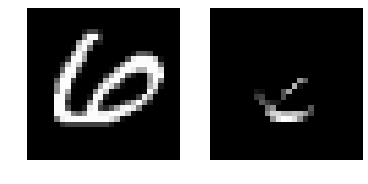

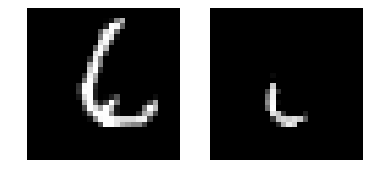

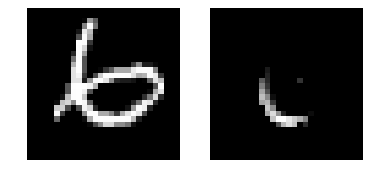

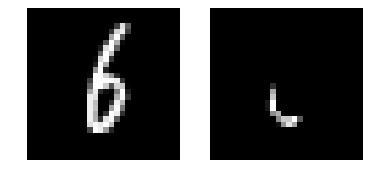

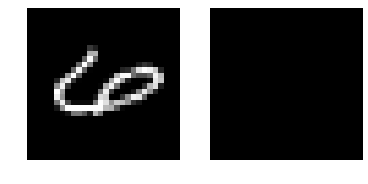

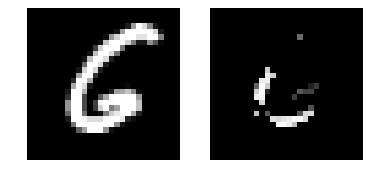

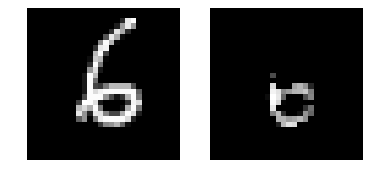

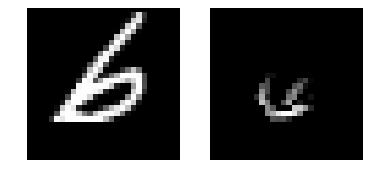

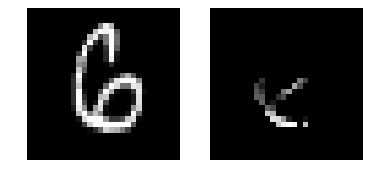

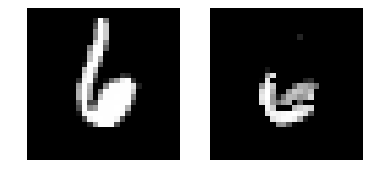

In [144]:
#sampling
#自分自身を再構成。
x = torch.tensor(l, dtype=torch.float, device=device) # instead of new_l
y, z = model(x)
y = y.cpu().detach().numpy()

size=l.shape[0]
new_x = l.reshape([size, 28, 28])
new_y = y.reshape([size, 28, 28])

for i in range(10):
  fig, axes = plt.subplots(1, 2)
  axes[0].set_axis_off()
  axes[0].imshow(new_x[i], cmap="gray")

  axes[1].set_axis_off()
  axes[1].imshow(new_y[i], cmap="gray")

  plt.show()

「６」を学習し、「９」を再構成するケース

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


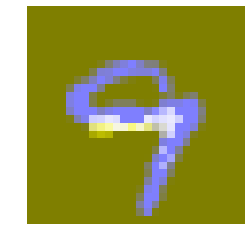

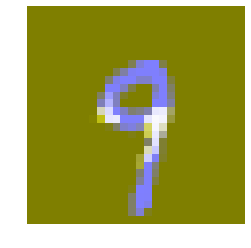

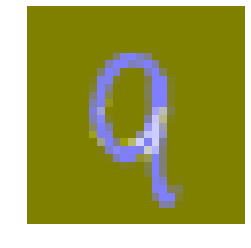

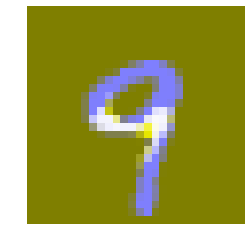

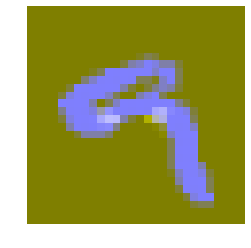

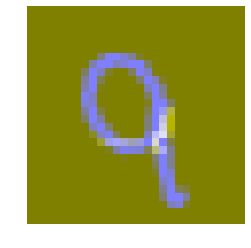

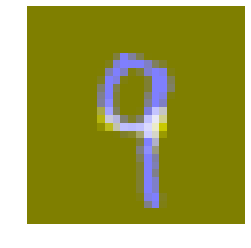

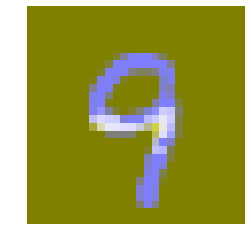

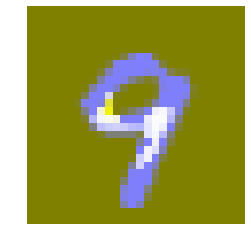

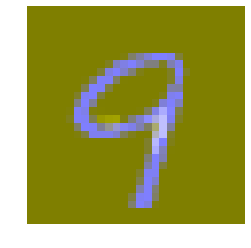

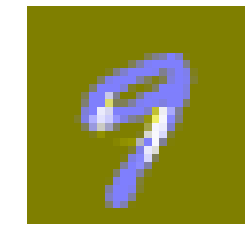

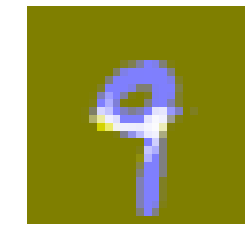

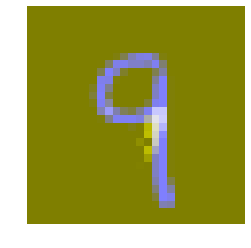

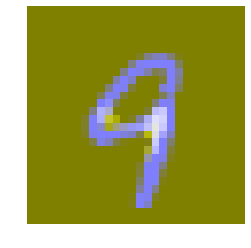

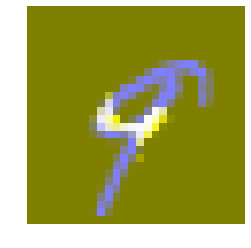

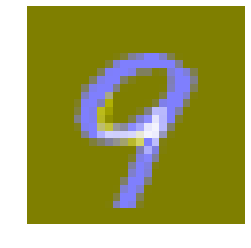

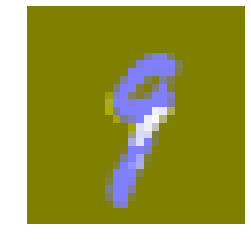

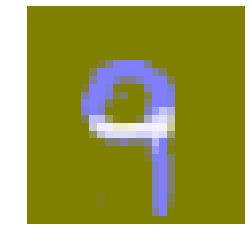

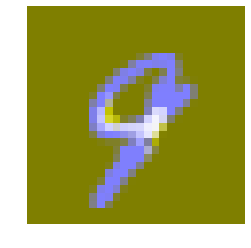

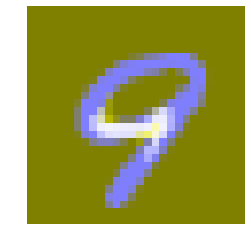

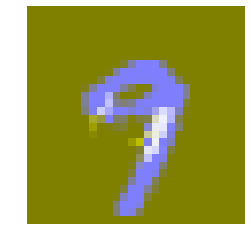

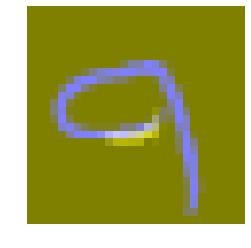

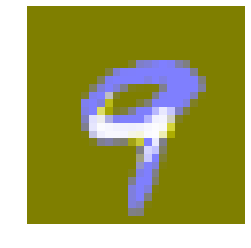

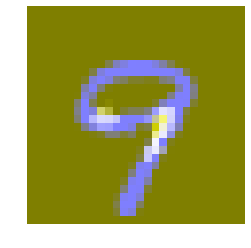

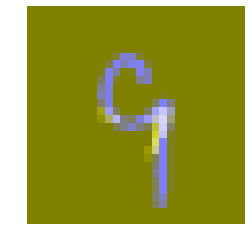

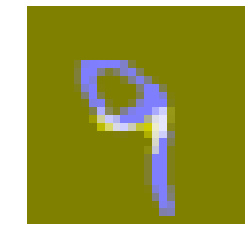

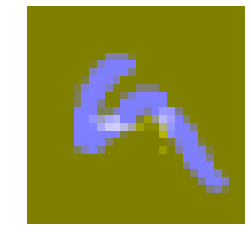

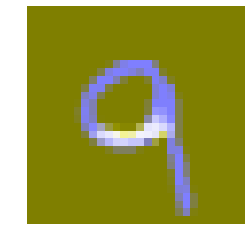

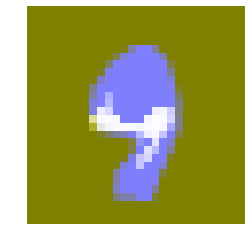

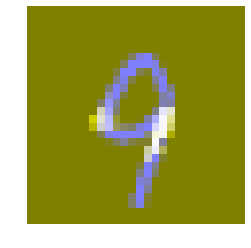

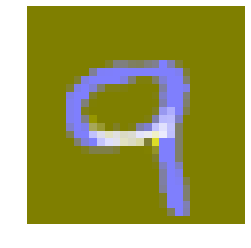

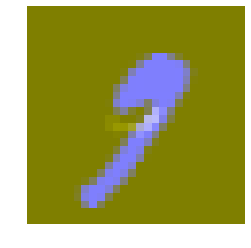

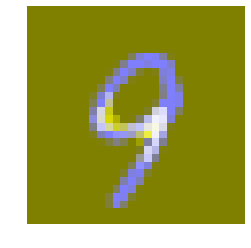

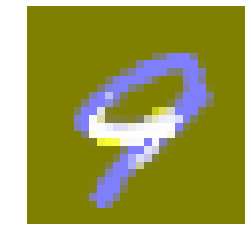

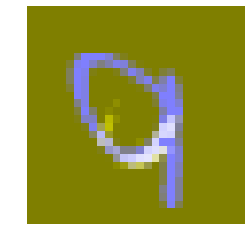

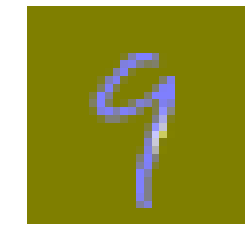

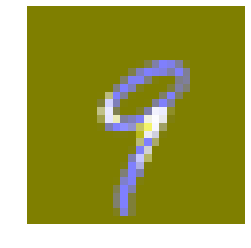

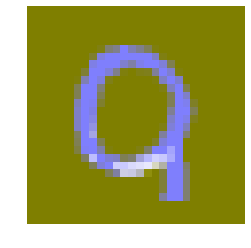

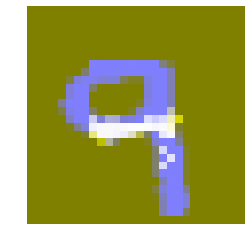

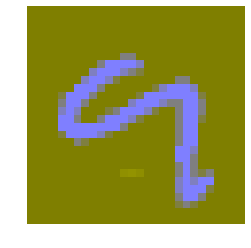

In [145]:
#9を再構成
inputs  = label_nine_data
x = torch.tensor(inputs, dtype=torch.float, device=device) # instead of new_l
y, z = model(x)
y = y.cpu().detach().numpy()

size=nine_size
new_x = inputs.reshape([size, 28, 28])
new_y = y.reshape([size, 28, 28])

hoge = np.zeros((nine_size, 28, 28, 3))
n = 40

for i in range(n):
  for j in range(28):
    for k in range(28):
      hoge[i][j][k][1] = new_y[i][j][k]
      hoge[i][j][k][2] = new_x[i][j][k]
      hoge[i][j][k][0] = new_y[i][j][k]

      
for i in range(40):
  fig, axes = plt.subplots()
  axes.set_axis_off()
  axes.imshow(hoge[i])
  plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


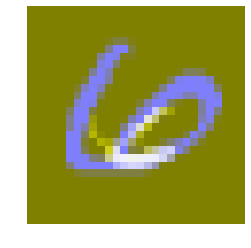

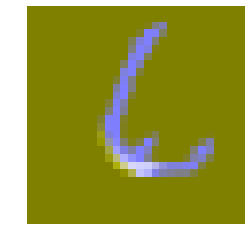

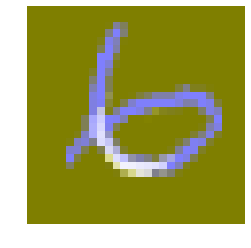

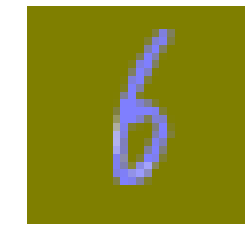

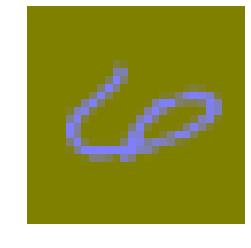

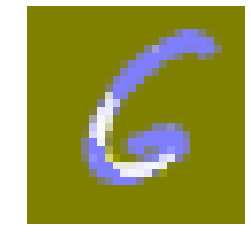

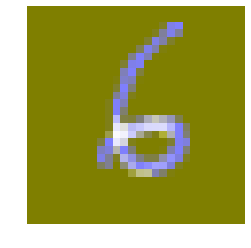

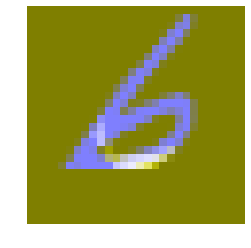

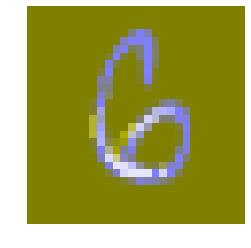

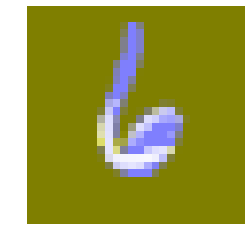

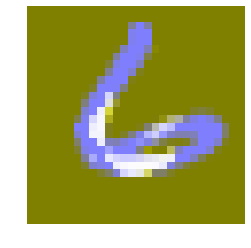

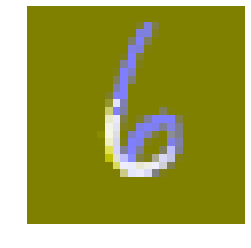

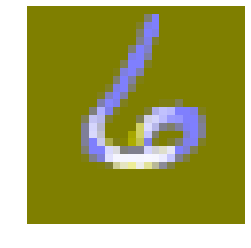

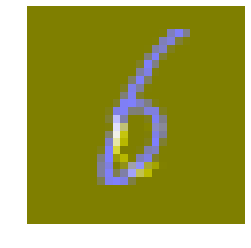

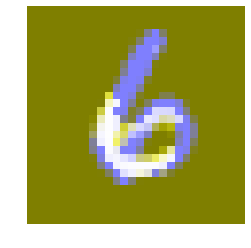

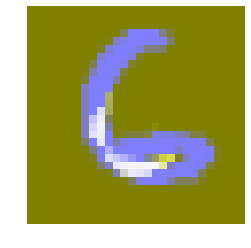

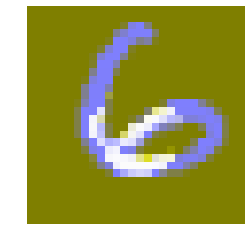

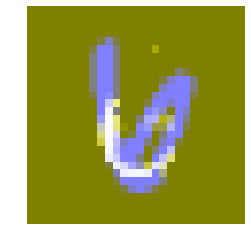

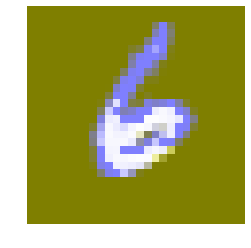

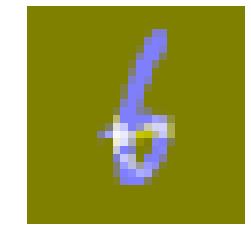

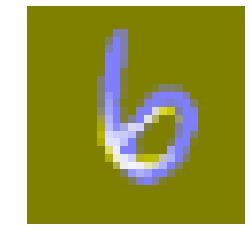

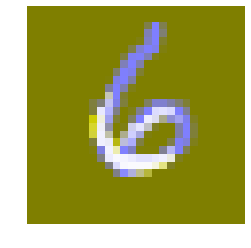

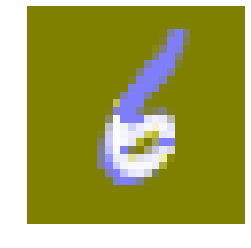

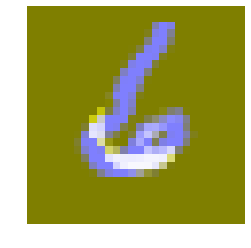

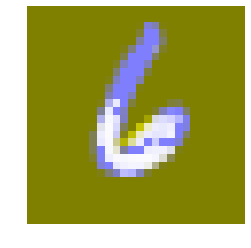

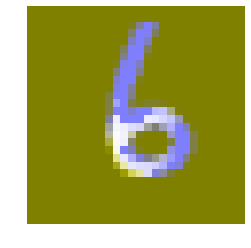

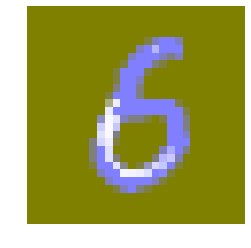

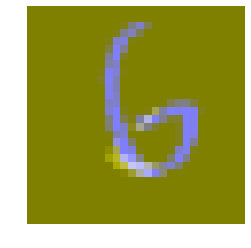

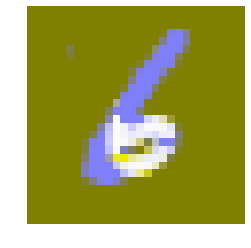

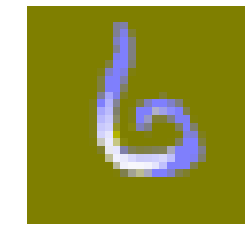

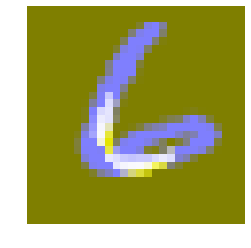

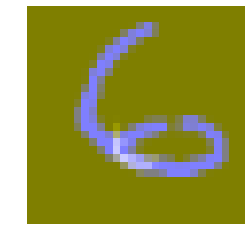

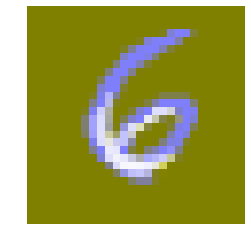

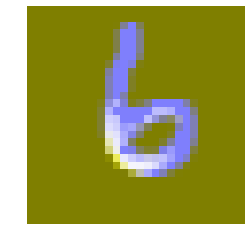

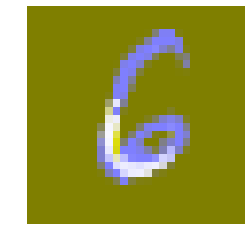

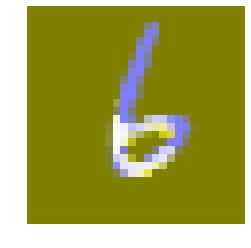

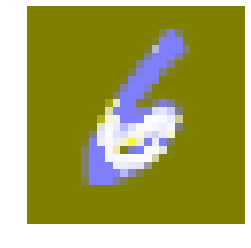

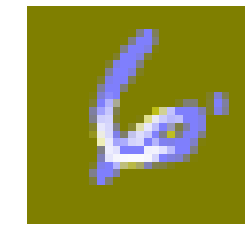

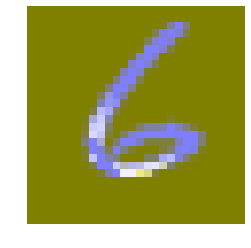

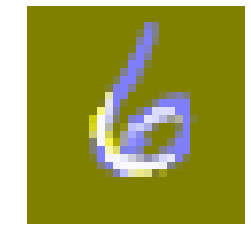

In [148]:
#6を再構成
inputs  = label_six_data
x = torch.tensor(inputs, dtype=torch.float, device=device) # instead of new_l
y, z = model(x)
y = y.cpu().detach().numpy()

size = six_size
new_x = inputs.reshape([size, 28, 28])
new_y = y.reshape([size, 28, 28])

hoge = np.zeros((nine_size, 28, 28, 3))
n = 40

for i in range(n):
  for j in range(28):
    for k in range(28):
      hoge[i][j][k][1] = new_y[i][j][k]
      hoge[i][j][k][2] = new_x[i][j][k]
      hoge[i][j][k][0] = new_y[i][j][k]

      
for i in range(40):
  fig, axes = plt.subplots()
  axes.set_axis_off()
  axes.imshow(hoge[i])
  plt.show()